In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
import math

daily_train = pd.read_csv('../../Datasets/Daily-train.csv')
daily_test = pd.read_csv('../../Datasets/Daily-test.csv')

__Selecting the Time Series Data for Our Predictions__

In [ ]:
train = daily_train.transpose()
test = daily_test.transpose()

train = train[0]
train = train.iloc[1:]
train = train.dropna()

test = test[0]
test = test.iloc[1:]

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

new_index = pd.RangeIndex(start=len(train), stop=len(train) + len(test))
test.index = new_index

train = pd.DataFrame(train)
train = train[0]
train = train.drop(columns=[0])
train = train.apply(pd.to_numeric)

test = pd.DataFrame(test)
test = test[0]
test = test.drop(columns=[0])
test = test.apply(pd.to_numeric)

series = pd.concat([train, test], axis=1, keys=['Train', 'Test'])

series1 = pd.concat([train, test], axis=0)

<AxesSubplot:>

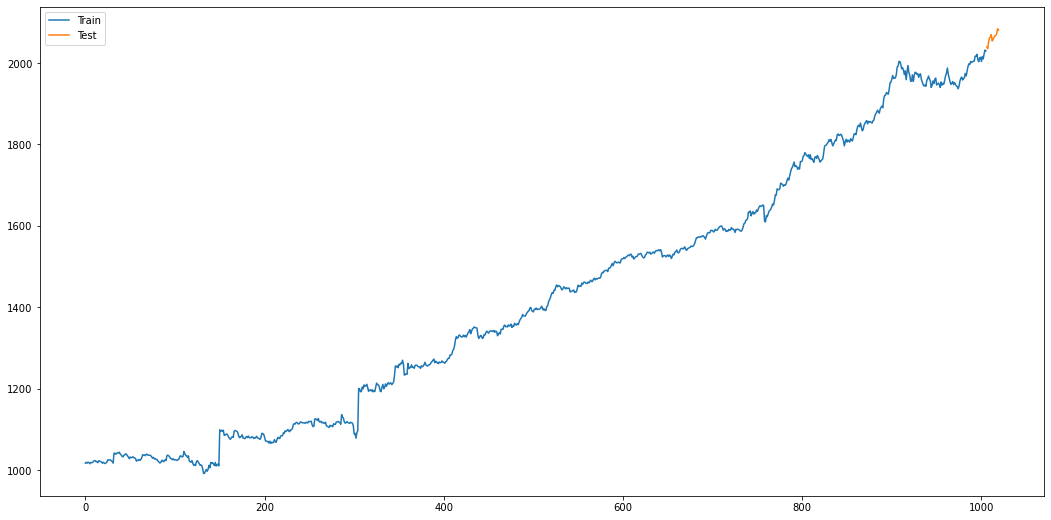

In [6]:
series.plot(figsize=(18,9))

__Data Preprocessing and Sequence Creation for LSTM Models__

In [9]:
df = train
df = df.values
df = df.astype('float32')
df = np.reshape(df, (-1,1))

scaler = MinMaxScaler()
df_scalled = scaler.fit_transform(df)

df_train, df_test = df_scalled[0:int(len(df_scalled)*0.66)], df_scalled[int(len(df_scalled)*0.66):]

def create_sequences(df, sequence_lenght, step):
  #  df_to_np = df.to_numpy()
    X = []
    y = []
    for i in range(0, len(df) - sequence_lenght, step):
        #X.append(df_to_np[i: i + sequence_lenght])
       # y.append(df_to_np[i + sequence_lenght])
        X.append(df[i: i + sequence_lenght, 0])
        y.append(df[i + sequence_lenght, 0])
    return np.array(X), np.array(y)

__Function for Multistep Time Series Forecasting__

In [44]:
def Forecasting(model, num_forecast,SEQUENCE_LENGHT):
     # Number of future values to forecast
    #num_forecast = 14

    # Reshape the test data for forecasting
    X_forecast = np.reshape(X_test[-1], (1, SEQUENCE_LENGHT, 1))

    # Generate the forecasts
    Forecast = []
    for _ in range(num_forecast):
        next_value = model.predict(X_forecast)
        Forecast.append(next_value)
        # Update X_forecast for the next prediction
        X_forecast = np.roll(X_forecast, -1, axis=1)
        X_forecast[0, -1, 0] = next_value

    # Reshape the forecasts array
    Forecast = np.array(Forecast).reshape(-1, 1)

    # Inverse transform the forecasts
    Forecast = scaler.inverse_transform(Forecast)

    # Print the forecasts
    print("Forecasts:")
    for i, forecast in enumerate(Forecast):
        print(f"Forecast {i+1}: {forecast[0]}")

    if num_forecast == len(test):
        Forecast = pd.DataFrame(Forecast)
        Forecast = Forecast.reset_index(drop=True)
        Forecast.index = new_index

        plt.figure(figsize=(15,8))
        plt.plot(Forecast, label='Forecast', color='green')
        plt.plot(test, label='Actual Test Data', color='black')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
    else:
        print("Work's only for 14 values to forecast")

    return Forecast

__Building and Training the First LSTM Model for Time Series Forecasting__

In [49]:
SEQUENCE_LENGHT = 7
SEQUENCE_STEP = 1

X_train, y_train = create_sequences(df_train, SEQUENCE_LENGHT, SEQUENCE_STEP)
X_test, y_test = create_sequences(df_test, SEQUENCE_LENGHT, SEQUENCE_STEP)

# Reshape input to be [samples, time steps, features]

X_train = np.reshape(X_train, (X_train.shape[0], SEQUENCE_LENGHT, SEQUENCE_STEP))
X_test = np.reshape(X_test, (X_test.shape[0], SEQUENCE_LENGHT, SEQUENCE_STEP))

# Create the model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(SEQUENCE_LENGHT, SEQUENCE_STEP)))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer=Adam(learning_rate=0.00001))
checkpoint = ModelCheckpoint('best_model_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=250, callbacks=[checkpoint])

Epoch 1/250
20/21 [===========================>..] - ETA: 0s - loss: 0.0775
Epoch 1: val_loss improved from inf to 0.57283, saving model to best_model_weights.h5
21/21 [==============================] - 6s 74ms/step - loss: 0.0769 - val_loss: 0.5728
Epoch 2/250
21/21 [==============================] - ETA: 0s - loss: 0.0753
Epoch 2: val_loss improved from 0.57283 to 0.56557, saving model to best_model_weights.h5
21/21 [==============================] - 0s 17ms/step - loss: 0.0753 - val_loss: 0.5656
Epoch 3/250
21/21 [==============================] - ETA: 0s - loss: 0.0742
Epoch 3: val_loss improved from 0.56557 to 0.55696, saving model to best_model_weights.h5
21/21 [==============================] - 0s 18ms/step - loss: 0.0742 - val_loss: 0.5570
Epoch 4/250
17/21 [=======================>......] - ETA: 0s - loss: 0.0747
Epoch 4: val_loss improved from 0.55696 to 0.54712, saving model to best_model_weights.h5
21/21 [==============================] - 0s 19ms/step - loss: 0.0728 - val_l

In [8]:
test

1006    2039.2
1007    2035.0
1008    2051.8
1009    2061.8
1010    2063.5
1011    2069.5
1012    2054.0
1013    2057.0
1014    2062.8
1015    2066.4
1016    2067.4
1017    2071.4
1018    2083.8
1019    2080.6
Name: 0, dtype: float64

1/1 [==============================] - 0s 32ms/step
Forecasts:
Forecast 1: 2014.7919921875
Forecast 2: 2015.9686279296875
Forecast 3: 2016.9586181640625
Forecast 4: 2020.740966796875
Forecast 5: 2021.61572265625
Forecast 6: 2024.1646728515625
Forecast 7: 2023.7528076171875
Forecast 8: 2021.037353515625
Forecast 9: 2022.6898193359375
Forecast 10: 2024.2198486328125
Forecast 11: 2025.6834716796875
Forecast 12: 2026.37158203125
Forecast 13: 2027.015869140625
Forecast 14: 2027.18798828125


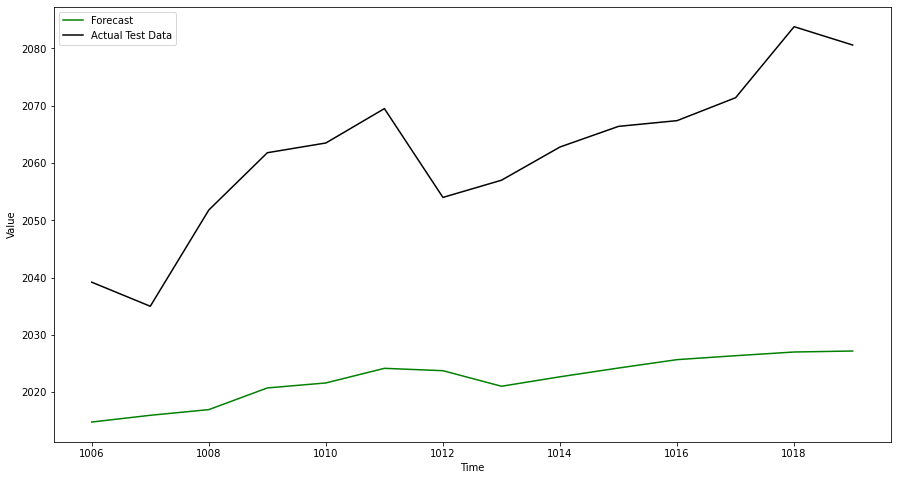

In [50]:
Forc_mod = Forecasting(model, len(test), SEQUENCE_LENGHT)

__Building and Training the SecondLSTM Model for Time Series Forecasting__

In [53]:
SEQUENCE_LENGHT = 120
SEQUENCE_STEP = 1

X_train, y_train = create_sequences(df_train, SEQUENCE_LENGHT, SEQUENCE_STEP)
X_test, y_test = create_sequences(df_test, SEQUENCE_LENGHT, SEQUENCE_STEP)

# Reshape input to be [samples, time steps, features]

X_train = np.reshape(X_train, (X_train.shape[0], SEQUENCE_LENGHT, SEQUENCE_STEP))
X_test = np.reshape(X_test, (X_test.shape[0], SEQUENCE_LENGHT, SEQUENCE_STEP))

# Create the model
model1 = Sequential()
model1.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(SEQUENCE_LENGHT, SEQUENCE_STEP)))
model1.add(LSTM(64, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(8, activation='relu'))
model1.add(Dense(1, activation='linear'))

model1.compile(loss='mse', optimizer=Adam(learning_rate=0.00006))
checkpoint1 = ModelCheckpoint('best_model1_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
history1 = model1.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=350, callbacks=[checkpoint1])

Epoch 1/350
17/17 [==============================] - ETA: 0s - loss: 0.1024
Epoch 1: val_loss improved from inf to 0.72853, saving model to best_model1_weights.h5
17/17 [==============================] - 13s 423ms/step - loss: 0.1024 - val_loss: 0.7285
Epoch 2/350
17/17 [==============================] - ETA: 0s - loss: 0.0926
Epoch 2: val_loss improved from 0.72853 to 0.67374, saving model to best_model1_weights.h5
17/17 [==============================] - 7s 405ms/step - loss: 0.0926 - val_loss: 0.6737
Epoch 3/350
17/17 [==============================] - ETA: 0s - loss: 0.0835
Epoch 3: val_loss improved from 0.67374 to 0.61895, saving model to best_model1_weights.h5
17/17 [==============================] - 6s 384ms/step - loss: 0.0835 - val_loss: 0.6189
Epoch 4/350
17/17 [==============================] - ETA: 0s - loss: 0.0745
Epoch 4: val_loss improved from 0.61895 to 0.56030, saving model to best_model1_weights.h5
17/17 [==============================] - 6s 378ms/step - loss: 0.074

In [7]:
test

1006    2039.2
1007    2035.0
1008    2051.8
1009    2061.8
1010    2063.5
1011    2069.5
1012    2054.0
1013    2057.0
1014    2062.8
1015    2066.4
1016    2067.4
1017    2071.4
1018    2083.8
1019    2080.6
Name: 0, dtype: float64

1/1 [==============================] - 0s 64ms/step
Forecasts:
Forecast 1: 1872.576416015625
Forecast 2: 1869.5419921875
Forecast 3: 1863.4351806640625
Forecast 4: 1854.9356689453125
Forecast 5: 1844.6429443359375
Forecast 6: 1833.043212890625
Forecast 7: 1820.54541015625
Forecast 8: 1807.486083984375
Forecast 9: 1794.1302490234375
Forecast 10: 1780.686279296875
Forecast 11: 1767.314697265625
Forecast 12: 1754.138916015625
Forecast 13: 1741.2510986328125
Forecast 14: 1728.719482421875


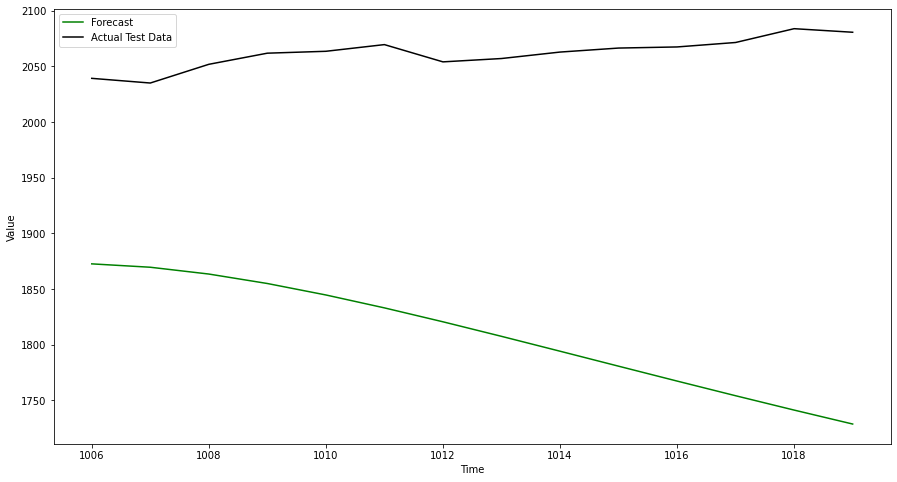

In [54]:
Forc_mod1 = Forecasting(model1, len(test),SEQUENCE_LENGHT)

__Comparing Training and Validation Loss: SimpleRNN vs LSTM__

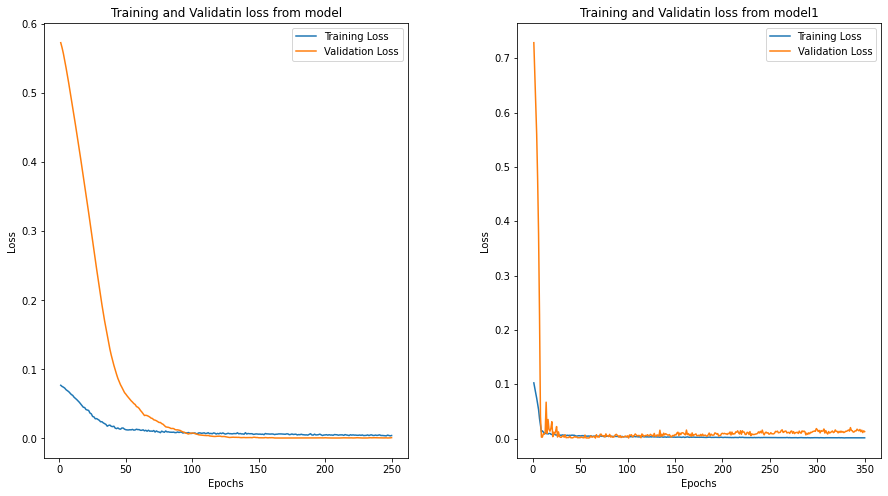

In [55]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
epochs1 = range(1, len(loss1)+1)


fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].plot(epochs, loss, label='Training Loss')
ax[0].plot(epochs, val_loss, label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validatin loss from model')
ax[0].legend()

ax[1].plot(epochs1, loss1, label='Training Loss')
ax[1].plot(epochs1, val_loss1, label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training and Validatin loss from model1')
ax[1].legend()

plt.subplots_adjust(wspace=0.3)

plt.show()

In [56]:
from sklearn.metrics import mean_squared_error

__Evaluating LSTM Models Using the RMSE Metric__

In [57]:
# Model
trainPred = model.predict(X_train)
testPred = model.predict(X_test)
trainPred = scaler.inverse_transform(trainPred)
testPred = scaler.inverse_transform(testPred)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

rmse_train = math.sqrt(mean_squared_error(y_train[0], trainPred[:, 0]))
rmse_test = math.sqrt(mean_squared_error(y_test[0], testPred[:, 0]))
print(f'For First model:\nThe RMSE for Train is {rmse_train}\nThe RMSE for Test is {rmse_test}') 

# Model1
trainPred1 = model1.predict(X_train)
testPred1 = model1.predict(X_test)
trainPred1 = scaler.inverse_transform(trainPred)
testPred1 = scaler.inverse_transform(testPred)

rmse_train1 = math.sqrt(mean_squared_error(y_train[0], trainPred1[:, 0]))
rmse_test1 = math.sqrt(mean_squared_error(y_test[0], testPred1[:, 0]))
print(f'For Second model:\nThe RMSE for Train is {rmse_train1}\nThe RMSE for Test is {rmse_test1}') 


7/7 [==============================] - 0s 66ms/step
For First model:
The RMSE for Train is 1507.5598983707696
The RMSE for Test is 2431.130019780447
7/7 [==============================] - 1s 97ms/step
For Second model:
The RMSE for Train is 2819269.8119175173
The RMSE for Test is 4492865.3293695785


__Visualizing Multistep Forecasting for Our Two Models__

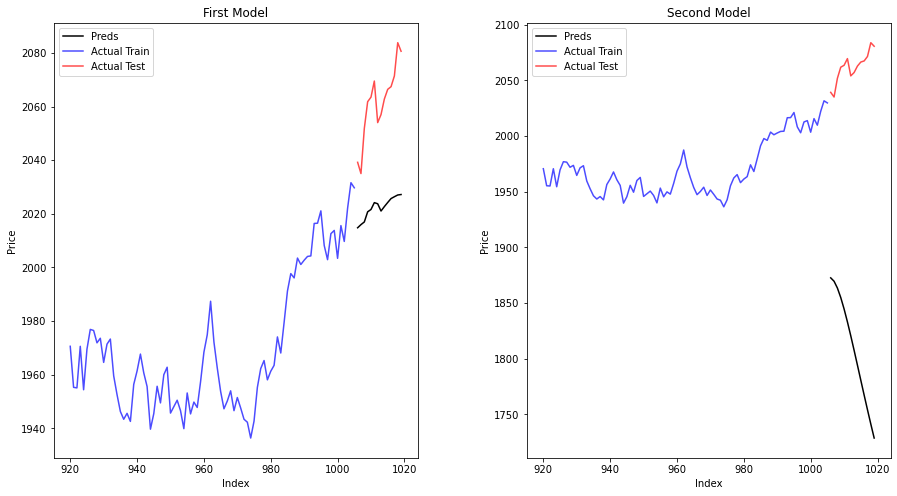

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Plotting the 1st model.
axs[0].plot(Forc_mod.tail(100), label='Preds', color='black')
axs[0].plot(series.Train.tail(100), label='Actual Train', color='blue', alpha=0.7)
axs[0].plot(series.Test.tail(100), label='Actual Test', color='red', alpha=0.7)
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Price')
axs[0].set_title('First Model')
axs[0].legend()

# Plotting the 2nd model.
axs[1].plot(Forc_mod1.tail(100), label='Preds', color='black')
axs[1].plot(series.Train.tail(100), label='Actual Train', color='blue', alpha=0.7)
axs[1].plot(series.Test.tail(100), label='Actual Test', color='red', alpha=0.7)
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Price')
axs[1].set_title('Second Model')
axs[1].legend()

plt.subplots_adjust(wspace=0.3)


plt.show()

__Conclusion:__<br><br>
- **Model 1 shows a better ability to make predictions that match the real data, even though it might not be very good at detecting patterns and has some big differences from the actual values.**<br><br>
- **On the other hand, Model 2 is too sensitive and tends to make predictions that are completely wrong because it tries to fit the data too closely, which is a problem called overfitting.**